In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import dataset
from utils.prefetch_queue_shuffle import PrefetchQueue
from utils.loss_utils import *
import numpy as np
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.data as dat
from datetime import datetime
import random
from random import shuffle
from slomo_model import SloMo_model
from utils.image_utils import imwrite
from functools import partial
import pdb
from utils.vgg16.vgg16 import vgg16

from scipy.misc import imread, imshow
import matplotlib.pyplot as plt
from dumbmod import Dumb

%matplotlib inline

In [2]:
img1_dir = '../data/triplets/walk_00220.jpg'
img2_dir = '../data/triplets/walk_00221.jpg'
img3_dir = '../data/triplets/walk_00222.jpg'
img4_dir = '../data/triplets/walk_00223.jpg'
img1 = imread(img1_dir)
img2 = imread(img2_dir)
img3 = imread(img3_dir)
img4 = imread(img4_dir)
imgs = [img1, img2, img3, img4]
imgs = [img.reshape([1, 352, 352, 3]) for img in imgs]
imgs = [img.astype(np.float32) for img in imgs]

/home/mark/Desktop/other/courses/DL/DL-env/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/home/mark/Desktop/other/courses/DL/DL-env/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/mark/Desktop/other/courses/DL/DL-env/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/home/mark/Desktop/other/courses/DL/DL-env/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [3]:
input_placeholder = np.concatenate([imgs[0], imgs[3]], axis=3)
target_placeholder = np.concatenate([imgs[1], imgs[2]], axis=3)

In [4]:
sess = tf.Session()

computer = Dumb(for_interpolation=False)
interpolater = Dumb(for_interpolation=True)
vgg_mod = vgg16(sess=sess)

# flow computation
flow_01, flow_10 = computer.inference(input_placeholder)

interp_outputs = {'flow_t0': [], 'flow_t1': [], 
                  'vis_mask_0': [], 'vis_mask_1': []}
image_0, image_1 = tf.convert_to_tensor(input_placeholder[:, :, :, :3]), \
                     tf.convert_to_tensor(input_placeholder[:, :, :, 3:])

total_loss = 0
pred_imgs_t = []
for idx, t in enumerate(np.arange(1.0/3., 0.999999, 1/3.)):
  # intermediate flow approximation at t, f_t0_hat
  flow_t0_hat = t * (-(1-t) * flow_01 + t * flow_10) 
  flow_t1_hat = (1-t) * ((1-t) * flow_01 - t * flow_10)

  # warp to approximate image_0, image_1 in inputs
  approx_img_0 = computer.warp(flow_10, image_1)
  approx_img_1 = computer.warp(flow_01, image_0)

  # interpolate
  interp_input = tf.concat([input_placeholder, 
                            approx_img_0, 
                            approx_img_1,
                            flow_t0_hat, 
                            flow_t1_hat], axis=3)
  flow_t0, flow_t1, vis_mask_0, vis_mask_1 = \
            interpolater.inference(interp_input)
  z = (1-t) * vis_mask_0 + t * vis_mask_1
  pred_img_t = (1 / z) * ((1-t) * vis_mask_0 
                           * computer.warp(-flow_t0, image_0) 
                           + t * vis_mask_1 
                           * computer.warp(-flow_t1, image_1))
  pred_imgs_t += [pred_img_t]
  # reconstruction loss
  target = target_placeholder[:, :, :, idx * 3: (idx + 1) * 3]
  loss_recons = l1_loss(pred_img_t, target) \
#                         / FLAGS.batch_size
  total_loss += 1. * loss_recons

  # perceptual loss
  phi_true = vgg_mod.inference(target)
  phi_pred = vgg_mod.inference(pred_img_t)
  loss_percept = l2_loss(phi_true, phi_pred) 
  total_loss += 0.8 * loss_percept

  # Lagrangian penalty to enforce constraint 
  loss_constraint = l1_regularizer(vis_mask_0 + vis_mask_1 - 1)
  total_loss += 10. * loss_constraint

# warping and smoothness losses
loss_warping = l1_loss(image_0, approx_img_0) \
                    + l1_loss(image_1, approx_img_1)
loss_smooth = l1_regularizer(flow_01) + l1_regularizer(flow_10)

total_loss += 1. * loss_warping \
                + 10. * loss_smooth

### TODO: try learning rate scheduling if needed
learning_rate = 1e-5

# Create an optimizer that performs gradient descent.
opt = tf.train.AdamOptimizer(learning_rate)
update_op = opt.minimize(total_loss)

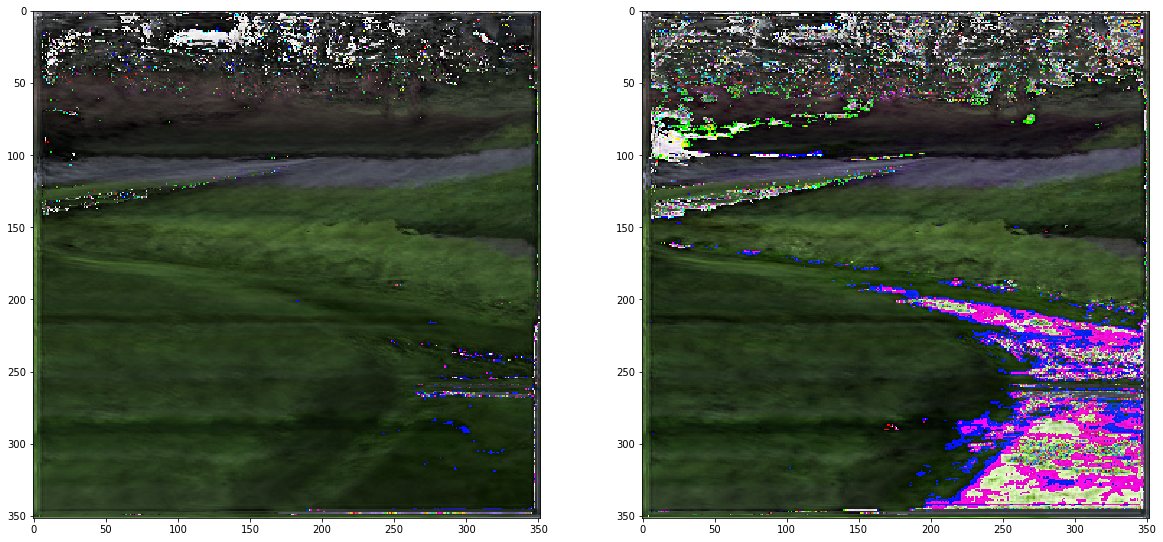

In [ ]:
init = tf.global_variables_initializer()
sess.run(init)
l, __, pred1, pred2 = sess.run([total_loss, update_op] + pred_imgs_t)
plt.figure(figsize=[20, 18])
plt.subplot(121)
plt.imshow(pred1[0].astype(np.uint8))
plt.subplot(122)
plt.imshow(pred2[0].astype(np.uint8))

In [ ]:
for step in range(1000):
    l, __, pred1, pred2 = sess.run([total_loss, update_op] + pred_imgs_t)
    if step % 100 == 0:
#         plt.figure(figsize=[20, 18])
#         plt.subplot(121)
        imshow(pred1[0].astype(np.uint8))
#         plt.subplot(122)
        imshow(pred2[0].astype(np.uint8))
    print('loss @ step '+str(step)+': ', l)

/home/mark/Desktop/other/courses/DL/DL-env/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imshow` is deprecated!
`imshow` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``matplotlib.pyplot.imshow`` instead.
  
/home/mark/Desktop/other/courses/DL/DL-env/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imshow` is deprecated!
`imshow` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``matplotlib.pyplot.imshow`` instead.
  


loss @ step 0:  86605.6
loss @ step 1:  88526.23
loss @ step 2:  17963.234
loss @ step 3:  26672.932
loss @ step 4:  247181.95
loss @ step 5:  6449.5615
loss @ step 6:  11549.013
loss @ step 7:  1065.4935
loss @ step 8:  803.67126
loss @ step 9:  479.1749
loss @ step 10:  2931.275
loss @ step 11:  524.0092
loss @ step 12:  7280.1035
loss @ step 13:  783.9626
loss @ step 14:  1250.8013
loss @ step 15:  406.61853
loss @ step 16:  325.2177
loss @ step 17:  358.33145
loss @ step 18:  932.6937
loss @ step 19:  335.44263
loss @ step 20:  826.47876
loss @ step 21:  1620.3385
loss @ step 22:  679.9584
loss @ step 23:  451.1435
loss @ step 24:  467.39587
loss @ step 25:  889.70184
loss @ step 26:  634.6396
loss @ step 27:  950.32715
loss @ step 28:  390.7608
loss @ step 29:  470.1232
loss @ step 30:  366.60315
loss @ step 31:  2217.349
loss @ step 32:  8991.304
loss @ step 33:  569.4069
loss @ step 34:  481.01532
loss @ step 35:  950.0667
loss @ step 36:  2358.3728
loss @ step 37:  447.98108
lo

In [ ]:
plt.figure(figsize=[40, 36])
plt.subplot(221)
plt.imshow(pred1[0].astype(np.uint8))
plt.subplot(222)
plt.imshow(target_placeholder[:, :, :, :3][0].astype(np.uint8))
plt.subplot(223)
plt.imshow(pred2[0].astype(np.uint8))
plt.subplot(224)
plt.imshow(target_placeholder[:, :, :, 3:][0].astype(np.uint8))